Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from collections import defaultdict
import gc
import os

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [94]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SimSiamLoss
from tensorflow_similarity.losses import SimCLRLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [95]:
tfsim.utils.tf_cap_memory() # Avoid GPU memory blow up

In [96]:
tf.keras.backend.clear_session() 
gc.collect()

31503

# Dataset

## Loading

In [97]:
(x_train, y_raw_train), (x_test, y_raw_test) = keras.datasets.cifar10.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_raw_train, 10)
y_test = keras.utils.to_categorical(y_raw_test, 10)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 10) y_test (10000, 10)


In [157]:
IMG_SIZE = 32
BATCH_SIZE = 128

# LR = 0.05
# INIT_LR = LR * BATCH_SIZE / 256.0
INIT_LR = 0.03
PRE_TRAIN_EPOCHS = 200
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

WEIGHT_DECAY = 0.0005

In [158]:
train_augmenter = SimCLRAugmenter(IMG_SIZE, IMG_SIZE, is_training=True)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 128 (128 classes * 1 examples per class) with 2 augmenters


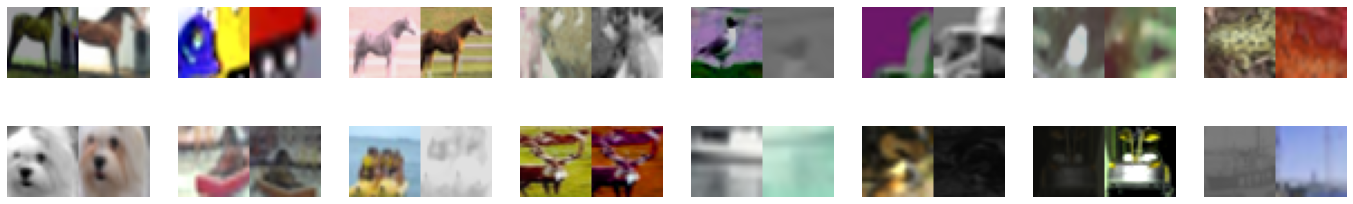

In [159]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## Backbone 

In [175]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [176]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1

In [177]:
def get_encoder(img_size, dim=2048, activation='relu', trainable=True):

    inputs = layers.Input((img_size, img_size, 3))
    # ResNet expects [-1,1], but our augmented images are [0,1]
    x = layers.Rescaling(scale=2, offset=-1)(inputs)
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)
    
    # Projection Head
    x = layers.Dense(dim, activation=activation, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(dim, activation=activation, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(dim, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    o = layers.BatchNormalization(center=False, scale=False)(x)

    backbone = Model(inputs, o, name='encoder')
    return backbone

simsiam_encoder = get_encoder(IMG_SIZE)
simsiam_encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 32, 32, 3)    0           input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 32, 32, 16)   432         rescaling_9[0][0]                
__________________________________________________________________________________________________
batch_normalization_201 (BatchN (None, 32, 32, 16)   64          conv2d_198[0][0]                 
____________________________________________________________________________________________

## Predictor model

In [178]:
def get_predictor(dim, hiddin_dim=512, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    
    x = layers.Dense(hiddin_dim, activation=activation, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = layers.BatchNormalization()(x)
    
    o = layers.Dense(dim)(x)
    projector = Model(inputs, o, name="predictor")
    return projector

simsiam_predictor = get_predictor(2048)
simsiam_predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               1048576   
_________________________________________________________________
batch_normalization_223 (Bat (None, 512)               2048      
_________________________________________________________________
dense_48 (Dense)             (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


# Loss

In [179]:
# This loss is minimizing either the cosine distance or the angular 
# distance and should be between [0, 4]
loss = SimSiamLoss(loss_type='angular_distance')
metrics = [[encoder_std], []]

# Pre Training

In [180]:
contrastive_model = ContrastiveModel(
    encoder_model=simsiam_encoder, 
    projector_model=simsiam_predictor, 
    swap_representation=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True
)
# use sgd as optimizer with constant loss as recommende in the paper.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INIT_LR, decay_steps=PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH
)
sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)
contrastive_model.compile(optimizer=sgd, loss=loss, metrics=metrics)

In [ ]:
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS, callbacks=[early_stopping])

Epoch 1/200
390/390 [==============================] - 145s 358ms/step - loss: 0.1336 - output_1_encoder_std: 0.0221
Epoch 2/200
390/390 [==============================] - 101s 260ms/step - loss: 0.1166 - output_1_encoder_std: 0.0221
Epoch 3/200
278/390 [====================>.........] - ETA: 29s - loss: 0.1132 - output_1_encoder_std: 0.0221

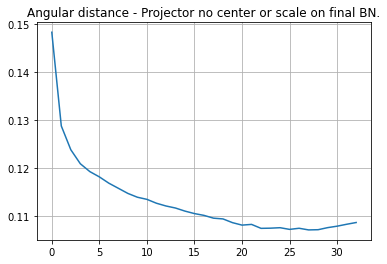

In [167]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Angular distance - Projector no center or scale on final BN.")
plt.show()

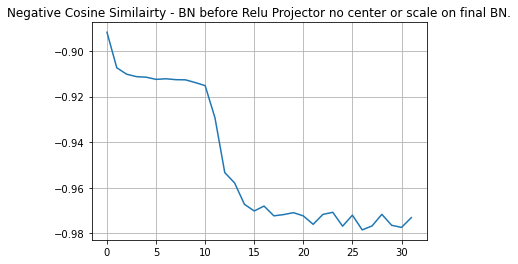

In [149]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Negative Cosine Similairty - BN before Relu Projector no center or scale on final BN.")
plt.show()

In [156]:
# Early stopping as loss was oscillating, but learned very quickly. Might work better with lower LR.
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 3.5510 - acc: 0.2998
no pretrain [3.5510411262512207, 0.29980000853538513]
313/313 [==============================] - 2s 5ms/step - loss: 3.2516 - acc: 0.3703
pretrained [3.2515995502471924, 0.3702999949455261]


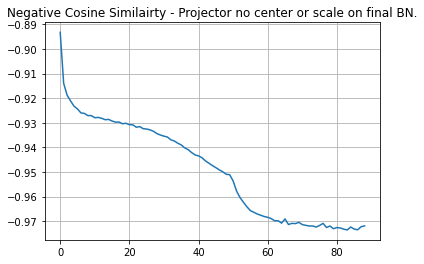

In [108]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Negative Cosine Similairty - Projector no center or scale on final BN.")
plt.show()

In [115]:
# Negative Cosine Similarity - Projector no center or scale on final BN. 100 examples per class
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.9956 - acc: 0.1669
no pretrain [4.99563455581665, 0.16689999401569366]
313/313 [==============================] - 2s 5ms/step - loss: 4.0802 - acc: 0.2223
pretrained [4.080162525177002, 0.2222999930381775]


In [139]:
# Negative Cosine Similarity - Projector no center or scale on final BN. 2000 examples per class
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.2093 - acc: 0.2090
no pretrain [4.209340572357178, 0.20900000631809235]
313/313 [==============================] - 2s 5ms/step - loss: 3.2375 - acc: 0.3798
pretrained [3.2375073432922363, 0.3797999918460846]


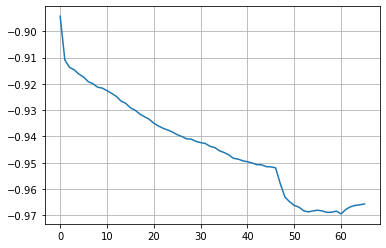

In [86]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [93]:
# Negative Cosine Similarity
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.6175 - acc: 0.1771
no pretrain [4.617520332336426, 0.17710000276565552]
313/313 [==============================] - 2s 5ms/step - loss: 3.9286 - acc: 0.2409
pretrained [3.9285616874694824, 0.24089999496936798]


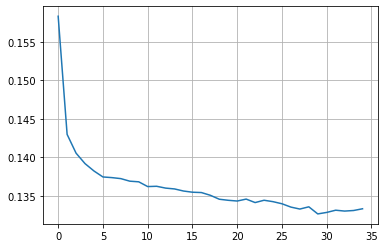

In [37]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title()
plt.title("Angular Distance")
plt.show()

In [44]:
# Angular distance
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 4.6792 - acc: 0.1805
no pretrain [4.67922830581665, 0.18050000071525574]
313/313 [==============================] - 2s 5ms/step - loss: 4.4734 - acc: 0.1981
pretrained [4.473399639129639, 0.1981000006198883]


# Distances after 5 epochs

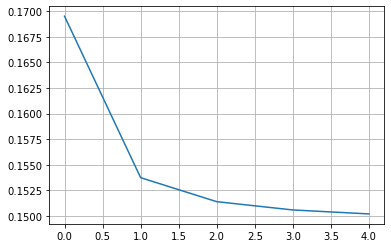

In [19]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Angular Distance")
plt.show()

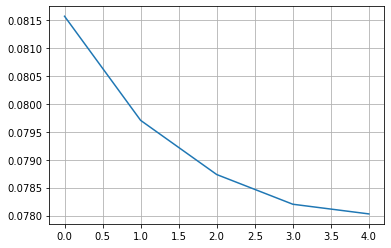

In [29]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Cosine Distance")
plt.show()

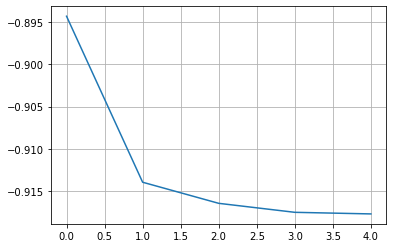

In [25]:
plt.plot(contrastive_history.history['loss'])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

# Evaluation

In [168]:
from tensorflow_similarity.samplers import select_examples

# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = select_examples(x_train, y_raw_train, num_examples_per_class=2000)
y_restricted = keras.utils.to_categorical(y_restricted, 10)

TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = len(x_restricted) // BATCH_SIZE

filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/20000 [00:00<?, ?it/s]

In [169]:
def get_eval_model(img_size, encoder):
    encoder.trainable = False
    inputs = layers.Input((img_size, img_size, 3))
    x = encoder(inputs, training=False)
    o = layers.Dense(10, activation='softmax')(x)
    model = Model(inputs, o, name='no_pretrain')
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
    return model

# No pretrain

In [170]:
no_pt_encoder = get_encoder(IMG_SIZE)
no_pt_encoder = Model(
    no_pt_encoder.input, no_pt_encoder.get_layer("backbone_pool").output
)
reg_model = get_eval_model(IMG_SIZE, no_pt_encoder)
reg_history = reg_model.fit(x_restricted, y_restricted, batch_size=BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
157/157 [==============================] - 4s 14ms/step - loss: 8.7656 - acc: 0.1709 - val_loss: 4.3275 - val_acc: 0.2200
Epoch 2/20
157/157 [==============================] - 2s 10ms/step - loss: 4.0877 - acc: 0.2222 - val_loss: 4.1129 - val_acc: 0.2187
Epoch 3/20
157/157 [==============================] - 2s 10ms/step - loss: 3.9311 - acc: 0.2423 - val_loss: 3.8161 - val_acc: 0.2484
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 3.8550 - acc: 0.2500 - val_loss: 3.6235 - val_acc: 0.2783
Epoch 5/20
157/157 [==============================] - 2s 10ms/step - loss: 3.7284 - acc: 0.2653 - val_loss: 3.8215 - val_acc: 0.2565
Epoch 6/20
157/157 [==============================] - 2s 10ms/step - loss: 3.7544 - acc: 0.2706 - val_loss: 4.1338 - val_acc: 0.1794
Epoch 7/20
157/157 [==============================] - 2s 10ms/step - loss: 3.7352 - acc: 0.2703 - val_loss: 3.6779 - val_acc: 0.2755
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - 

# Pretrained with SiamSiam

In [171]:
contrastive_model.projector.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1048576   
_________________________________________________________________
batch_normalization_178 (Bat (None, 512)               2048      
_________________________________________________________________
dense_38 (Dense)             (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


In [172]:
# Extract the backbone ResNet20.
pt_encoder = Model(
    contrastive_model.get_encoder().input, contrastive_model.get_encoder().get_layer("backbone_pool").output
)
model2 = get_eval_model(IMG_SIZE, pt_encoder)
model2.summary()

Model: "no_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_10 (Functional)        (None, 256)               568368    
_________________________________________________________________
dense_43 (Dense)             (None, 10)                2570      
Total params: 570,938
Trainable params: 2,570
Non-trainable params: 568,368
_________________________________________________________________


In [173]:
pre_history = model2.fit(x_restricted, y_restricted, batch_size=BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
157/157 [==============================] - 5s 19ms/step - loss: 5.9568 - acc: 0.1694 - val_loss: 4.2077 - val_acc: 0.1968
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 3.9105 - acc: 0.2182 - val_loss: 3.8212 - val_acc: 0.2427
Epoch 3/20
157/157 [==============================] - 2s 11ms/step - loss: 3.7634 - acc: 0.2397 - val_loss: 3.8362 - val_acc: 0.2370
Epoch 4/20
157/157 [==============================] - 2s 10ms/step - loss: 3.6854 - acc: 0.2594 - val_loss: 3.7107 - val_acc: 0.2455
Epoch 5/20
157/157 [==============================] - 2s 11ms/step - loss: 3.6102 - acc: 0.2685 - val_loss: 3.6537 - val_acc: 0.2565
Epoch 6/20
157/157 [==============================] - 2s 10ms/step - loss: 3.6299 - acc: 0.2705 - val_loss: 3.6448 - val_acc: 0.2494
Epoch 7/20
157/157 [==============================] - 2s 11ms/step - loss: 3.5708 - acc: 0.2839 - val_loss: 3.7708 - val_acc: 0.2434
Epoch 8/20
157/157 [==============================] - 2s 10ms/step - 

In [174]:
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 3.5445 - acc: 0.3013
no pretrain [3.544525384902954, 0.3012999892234802]
313/313 [==============================] - 2s 5ms/step - loss: 3.4142 - acc: 0.3173
pretrained [3.414243698120117, 0.3172999918460846]
